# Tokens cleaning and topic modelling

In [1]:

import sys
sys.path.append("..")

from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import json

from src.dataset import Dataset
from src.tokenizers import BatchTokenizer
from src.vectorizers import TokenTfidfVectorizer

## Tokens analysis and cleaning

We start by loading the tokens and by plotting the document length.

In [3]:
dataset = Dataset(dataset_path="", save_path=f"../data/processed/tokenized_processed.json")
tokens = dataset.load_text_list(field_name="tokens", size=-1)

In [4]:
x = [len(x) for x in tokens]

fun = [max, min, np.mean, np.std]

print("Length stats:")
pprint([(f.__name__, f(x)) for f in fun])

Length stats:
[('max', 27266),
 ('min', 0),
 ('mean', 897.4436938559213),
 ('std', 952.6769893631284)]


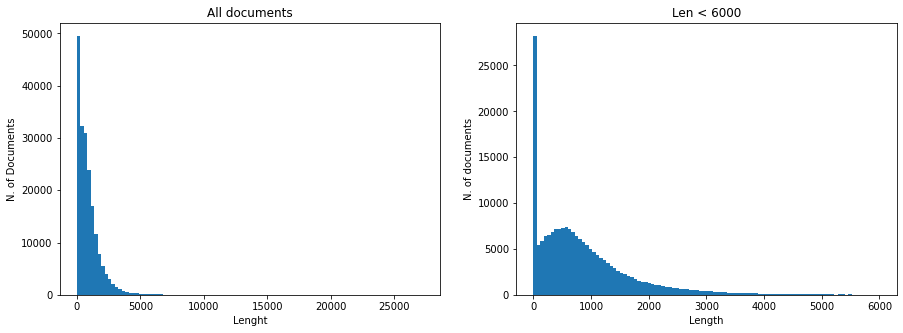

In [5]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].hist(x, bins=100)
axs[1].hist(list(filter(lambda x:x<6000, x)), bins=100)
axs[0].set(title= "All documents", 
           xlabel="Lenght", ylabel="N. of Documents")
axs[1].set(title= "Len < 6000", 
           xlabel="Lenght", ylabel="N. of Documents")

plt.xlabel("Length")
plt.ylabel("N. of documents")
plt.show()

Apart from some excessively long documents, most of the documents are in the 0-5000 length range. The longest one may requires some investigation.

In [6]:
print(f"Index of longest document: {np.argmax(x)}")

Index of longest document: 193868


### Zipf curve

We start by computing the document frequency for each token, we can clearly see some tokens are heavily used, mean and max are really distant.

In [7]:
freqs = defaultdict(lambda:0)

for doc in tokens:
    for t in set(doc):
        freqs[t] += 1

f = list(freqs.values())

In [8]:
print("Terms frequency stats:")
pprint([(g.__name__, g(f)) for g in fun])
len(f)

Terms frequency stats:
[('max', 180590),
 ('min', 1),
 ('mean', 138.16451797044812),
 ('std', 2286.1170485009457)]


455470

We now consider terms that appear at least min_cutoff times. 

In [9]:
min_cutoff = 9 #we need this to include fentanyl
h = lambda x : x >= min_cutoff
nh = lambda x : x < min_cutoff

s_f = list(filter(h, f))
print("Filtered terms frequency stats:")
pprint([(g.__name__, g(s_f)) for g in fun])
len(s_f)

Filtered terms frequency stats:
[('max', 180590),
 ('min', 9),
 ('mean', 869.5295193932707),
 ('std', 5710.783603212675)]


71597

In [10]:
print(f"The most common term appears in the {round(max(s_f)/len(tokens), 2)}% of documents.")
print(f"There are {len(list(filter(nh, f)))} terms that appear less than {min_cutoff} times.")

The most common term appears in the 0.93% of documents.
There are 383873 terms that appear less than 9 times.


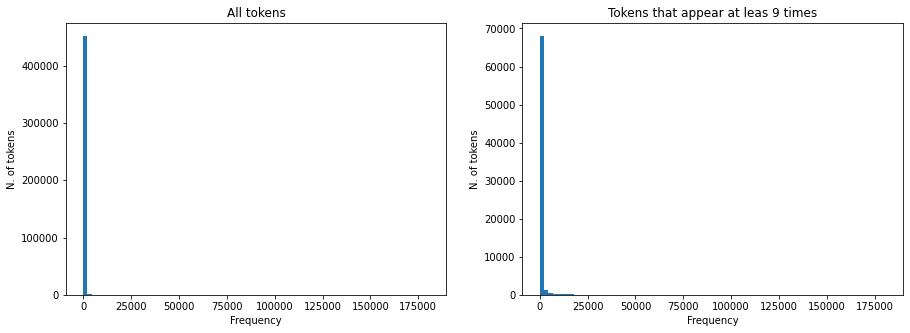

In [11]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].hist(f, bins=80)
axs[1].hist(s_f, bins=80)
axs[0].set(title= "All tokens", 
           xlabel="Frequency", ylabel="N. of tokens")
axs[1].set(title= "Tokens that appear at leas 9 times", 
           xlabel="Frequency", ylabel="N. of tokens")

plt.show()

### Collect and remove unused terms

The vocabulary drastically shrinks from 450k to 71k words by filtering out the terms that appears less than 9 times, this can be seen in later vectorization, but also from the stats presented above.

In [12]:
irrelevant_terms = set([ k for k,v in freqs.items() if nh(v)])

In [13]:
list(irrelevant_terms)[:5]

['nits', 'mumbled', 'dudak', 'eepartment', 'prosé']

In [14]:
filtered_tokens = [[t for t in doc if t not in irrelevant_terms] for doc in tokens]

In [2]:
# with open("../data/processed/filtered_tokens.json", "w") as f: 
#     f.write(json.dumps(filtered_tokens))
    
filtered_tokens = json.load(open("../data/processed/filtered_tokens.json", "r"))

## Searching terms about three topics

We start by checking for the presence of drugs, weapons and investigation terms.

In [3]:
narcotics = ['cannabis',
             'cocaine',
             'methamphetamine',
             'drugs',
             'drug',
             'marijuana',
             'ecstasy',
             'lsd',
             'ketamine',
             'heroin',
             'fentanyl', 
             'overdose', 
             'od']

weapons = ['gun',
           'knife',
           'weapon',
           'firearm',
           'rifle',
           'carabine',
           'shotgun',
           'handgun',
           'revolver',
           'musket',
           'pistol',
           'derringer',
           'assault',
           'rifle',
           'sword',
           'blunt']

investigation = ['gang',
                 'mafia',
                 'serial', 
                 'killer',
                 'rape',
                 'theft',
                 'recidivism',
                 'arrest',
                 'robbery',
                 'cybercrime',
                 'cyber', 
                #  'caucasian',
                #  'afro-american',
                #  'native', 
                #  'american',
                #  'hispanic',
                #  'male',
                #  'female',
                #  'man',
                #  'woman',
                #  'girl',
                #  'boy',
                 'crime']

In [4]:
seen = set()
not_found = set(weapons + investigation + narcotics)
freq = defaultdict(lambda:0)
for doc in filtered_tokens:
    # if not not_found:
    #     break
    for w in set(doc): 
        if w in not_found:
            # not_found.remove(w)
            seen.add(w)
            freq[w] += 1

In [5]:
pprint(sorted([(v,k) for k,v in freq.items()]))
print("Not found")
pprint(not_found-seen)

[(9, 'ecstasy'),
 (21, 'od'),
 (47, 'mafia'),
 (69, 'derringer'),
 (140, 'methamphetamine'),
 (178, 'drugs'),
 (205, 'recidivism'),
 (222, 'overdose'),
 (227, 'lsd'),
 (333, 'sword'),
 (540, 'killer'),
 (672, 'serial'),
 (777, 'blunt'),
 (945, 'rifle'),
 (1497, 'heroin'),
 (1570, 'cannabis'),
 (1581, 'handgun'),
 (1606, 'shotgun'),
 (2079, 'marijuana'),
 (2106, 'gang'),
 (2472, 'firearm'),
 (2739, 'pistol'),
 (2791, 'cocaine'),
 (2813, 'revolver'),
 (3709, 'knife'),
 (3925, 'rape'),
 (6161, 'theft'),
 (7868, 'assault'),
 (7988, 'weapon'),
 (9239, 'drug'),
 (9248, 'robbery'),
 (9526, 'gun'),
 (23893, 'arrest'),
 (24858, 'crime')]
Not found
{'cyber', 'cybercrime', 'ketamine', 'fentanyl', 'carabine', 'musket'}
